#### Advanced Statistics for Data Science (Spring 2022)
# Home Assignment 6
#### Topics:
- Multiple Regression
- Model/Variable Selection

#### Due: 07/06/2022 by 18:30

#### Instructions:
- Write your name, Student ID, and date in the cell below. 
- Submit a copy of this notebook with code filled in the relevant places as the solution of coding excercises.
- For theoretic excercises, you can either write your solution in the notebook using $\LaTeX$ or submit additional notes.

<hr>
<hr>


**Name**: Eyal Michaeli

**Student ID**: 207380528

**Date**: 10.05.22

$
\newcommand{\Id}{{\mathbf{I}}}  
\newcommand{\SSE}{\mathsf{SSE}}
\newcommand{\SSR}{\mathsf{SSR}}
\newcommand{\MSE}{\mathsf{MSE}}
\newcommand{\simiid}{\overset{iid}{\sim}}
\newcommand{\ex}{\mathbb E}
\newcommand{\var}{\mathrm{Var}}
\newcommand{\Cov}[2]{{\mathrm{Cov}  \left(#1, #2 \right)}}
\newcommand{\one}[1]{\mathbf 1 {\left\{#1\right\}}}
\newcommand{\SE}[1]{\mathrm{SE} \left[#1\right]}
\newcommand{\reals}{\mathbb R}
\newcommand{\Ncal}{\mathcal N}
\newcommand{\abs}[1]{\ensuremath{\left\vert#1\right\vert}}
\newcommand{\rank}{\operatorname{rank}}
\newcommand{\tr}{\operatorname{Tr}}
\newcommand{\diag}{\operatorname{diag}}
\newcommand{\sign}{\operatorname{sign}}
$


<hr>
<hr>

## Problem 1 (Multiple Regression)

Use the house prices dataset from class. Load it using the function ``load_house_prices_data``. We will use ``LogSalePrice`` as the targert variable (note that this is a transformed version of the original sale prince)

1. Use all varaibles in the data reteruned by ``load_house_prices_data``. Find at least one pair of competing predictors.
2. A constuction company is trying to figure out how to design a new development for maximal profit. They propose that since ``SecondFlrSF`` (second floor square footage, proportional to second floor square meter) is correlated with ``SalePrice``, they should try and maximize second floor area in their designs. Does this conclusion make sense considering that ``SecondFlrSF`` is correlated with``TotRmsAbvGrd``? offer a procedure that checks the effect of ``SecondFlrSF`` on ``SalePrice`` and gives more information to make such decision.


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

plt.style.use('seaborn')
sns.set(font_scale=1.4)

In [2]:
def load_house_prices_data(path = "housing_prices.csv"):
    """
    Args:
    -----
    path:  path to csv file
    
    Load and clean house prices data:
        filters for numeric predictors only
        filters for small lots only
        renames varaibles so that all variable names begins with [a-z]
        applies a variance stabilizing transformation to SalePrice
        removes outliers
        
    """
    
    
    def detect_outliers(df, q=0.01):
        lower_outliers = df < df.quantile(q)
        upper_outliers = df > df.quantile(1-q)
        return lower_outliers | upper_outliers
    
    data_raw = pd.read_csv(path)
    data1 = data_raw[data_raw.LotArea < 15000]  # focus on small lots
    data1 = data1.select_dtypes('number').dropna()
    data1 = data1.rename( # stats model formula cannot have
        # covaraite names starting with non letter
        columns = {'1stFlrSF': 'FirstFlrSF',
                   '2ndFlrSF': 'SecondFlrSF'}) 
                                                              
    variables =[
        # replaced this: 'LogSalePrice', with this:
        'SalePrice',
        'LotArea', 
        'YearBuilt',
         'YrSold', 'MoSold', 
         'Fireplaces', 
        'GarageCars', 'ScreenPorch', 
         'HalfBath', 'FullBath',
         'GrLivArea', 
         'BedroomAbvGr',
        'FirstFlrSF', 
        'SecondFlrSF',
        'TotRmsAbvGrd',
        'LowQualFinSF', 'TotalBsmtSF',
        'LotFrontage', 'WoodDeckSF',
         'OverallQual',
         'OverallCond'
    ]

    data1 = data1.filter(variables).dropna()
    data1['LogSalePrice'] = np.log(1 + data1['SalePrice'])
    data1 = data1.drop('SalePrice', axis=1)
    
    mask = detect_outliers(data1, .01).any(1)
    print(f"Masked a fraction of {mask.mean()} of the data due to outliers")
    return data1[~mask]


1. Use all varaibles in the data reteruned by ``load_house_prices_data``. Find at least one pair of competing predictors.

In [3]:
df = load_house_prices_data()
df.head()

Masked a fraction of 0.14971209213051823 of the data due to outliers


,LotArea,YearBuilt,YrSold,MoSold,Fireplaces,GarageCars,ScreenPorch,HalfBath,FullBath,GrLivArea,...,FirstFlrSF,SecondFlrSF,TotRmsAbvGrd,LowQualFinSF,TotalBsmtSF,LotFrontage,WoodDeckSF,OverallQual,OverallCond,LogSalePrice
0,8450,2003,2008,2,0,2,0,1,2,1710,...,856,854,8,0,856,65.0,0,7,5,12.247699
1,9600,1976,2007,5,1,2,0,0,2,1262,...,1262,0,6,0,1262,80.0,298,6,8,12.109016
2,11250,2001,2008,9,1,2,0,1,2,1786,...,920,866,6,0,920,68.0,0,7,5,12.317171
3,9550,1915,2006,2,1,3,0,0,1,1717,...,961,756,7,0,756,60.0,0,7,5,11.849405
4,14260,2000,2008,12,1,3,0,1,2,2198,...,1145,1053,9,0,1145,84.0,192,8,5,12.429220


In [4]:
df.describe()

,LotArea,YearBuilt,YrSold,MoSold,Fireplaces,GarageCars,ScreenPorch,HalfBath,FullBath,GrLivArea,...,FirstFlrSF,SecondFlrSF,TotRmsAbvGrd,LowQualFinSF,TotalBsmtSF,LotFrontage,WoodDeckSF,OverallQual,OverallCond,LogSalePrice
count,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,...,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000
mean,8870.092551,1973.720090,2007.761851,6.319413,0.536117,1.828442,11.141084,0.354402,1.564334,1450.688488,...,1134.227991,316.189616,6.382619,0.270880,1038.489842,67.950339,83.306998,6.121896,5.556433,12.017212
std,2712.163897,29.460509,1.330541,2.655047,0.586423,0.619753,42.905801,0.478602,0.516215,394.306574,...,320.537352,398.269103,1.309372,4.649888,365.594189,18.012231,105.469617,1.247295,0.968824,0.333021
min,1680.000000,1900.000000,2006.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,747.000000,...,520.000000,0.000000,4.000000,0.000000,0.000000,21.000000,0.000000,3.000000,3.000000,11.198228
25%,7400.750000,1954.000000,2007.000000,5.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1144.000000,...,893.250000,0.000000,5.000000,0.000000,806.000000,60.000000,0.000000,5.000000,5.000000,11.775297
50%,9049.000000,1976.000000,2008.000000,6.000000,0.000000,2.000000,0.000000,0.000000,2.000000,1430.500000,...,1072.000000,0.000000,6.000000,0.000000,981.000000,70.000000,0.000000,6.000000,5.000000,11.979805
75%,10592.750000,2003.000000,2009.000000,8.000000,1.000000,2.000000,0.000000,1.000000,2.000000,1703.500000,...,1340.000000,698.000000,7.000000,0.000000,1262.000000,80.000000,164.250000,7.000000,6.000000,12.240479
max,14598.000000,2009.000000,2010.000000,12.000000,2.000000,3.000000,260.000000,1.000000,3.000000,2730.000000,...,2073.000000,1330.000000,11.000000,80.000000,2046.000000,120.000000,431.000000,9.000000,8.000000,12.887130


Competing columns definition (from lecture): given 2 columns, the OLS coefficent of col1 is significant --> OLS coefficent of col2 is in-significant. and the same way around.
<br>
So, we will check if for some pairs, the OLS coefficent of some column will be significant only if a different col as been removed has a predictor. 
<br>
So first, we'll caclulate a full_model (with all predictors).
<br>
Then, we'll iterate over the predictors to find competing columns.

In [8]:
from itertools import combinations
from scipy.stats import t

dof = len(df) - 2
ALPHA = 0.05

predictors_cols = [col for col in df.columns if col != "LogSalePrice"]
predictors_pairs = list(combinations(predictors_cols, r=2))
print(f"There are a total of {len(predictors_pairs)} pairs of predictors in our dataset")

# calc full model
full_model = smf.ols(f"LogSalePrice ~ {' + '.join(predictors_cols)} + 1", df).fit()

competing_cols = list()
# iterate the pairs, find competing cols
for col1 in predictors_cols:
    other_cols = [col for col in predictors_cols if col != col1]  # get all the other columns without col1

    # calc part model (without col1)
    part_model = smf.ols(f"LogSalePrice ~ {' + '.join(other_cols)} + 1", df).fit()

    # find competing cols
    for other_col in other_cols:

        if full_model.pvalues[other_col] > ALPHA and part_model.pvalues[other_col] < ALPHA:
            print(f"{col1} and {other_col} are competing variables")
            competing_cols.append((col1, other_col))
    
print(f"\n\nThere are a total of {len(competing_cols)} competing columns in the dataset")


There are a total of 190 pairs of predictors in our dataset
LotArea and LotFrontage are competing variables
YearBuilt and FullBath are competing variables
YearBuilt and LotFrontage are competing variables
MoSold and LotFrontage are competing variables
Fireplaces and LotFrontage are competing variables
GarageCars and LotFrontage are competing variables
GrLivArea and FirstFlrSF are competing variables
GrLivArea and SecondFlrSF are competing variables
BedroomAbvGr and TotRmsAbvGrd are competing variables
FirstFlrSF and GrLivArea are competing variables
SecondFlrSF and GrLivArea are competing variables
TotRmsAbvGrd and LotFrontage are competing variables
TotalBsmtSF and LotFrontage are competing variables
OverallQual and MoSold are competing variables
OverallCond and LotFrontage are competing variables


There are a total of 15 competing columns in the dataset


2. A constuction company is trying to figure out how to design a new development for maximal profit. They propose that since ``SecondFlrSF`` (second floor square footage, proportional to second floor square meter) is correlated with ``SalePrice``, they should try and maximize second floor area in their designs. Does this conclusion make sense considering that ``SecondFlrSF`` is correlated with``TotRmsAbvGrd``? offer a procedure that checks the effect of ``SecondFlrSF`` on ``SalePrice`` and gives more information to make such decision.

Firstly, we usually shouldn't make decisions based on correlation, since correlation != causation.

In order for us to decide regarding this, it will be smart to know if, ``SecondFlrSF`` and ``LogSalePrice`` are partially correlative, adjusted for ``TotRmsAbvGrd``.
<br>
For that, we'll calculate the partial correlation of ``SecondFlrSF`` and ``LogSalePrice`` adjusted for ``TotRmsAbvGrd``

First, let's calculate the correlation & p-value without controlling:

In [12]:
from scipy.stats import pearsonr


varX = 'SecondFlrSF'
varY = 'LogSalePrice'
varZ = 'TotRmsAbvGrd' # total rooms above ground level

# calc regular pearson correlation
pearson, p_val = pearsonr(df[varX], df[varY])
print(f"{varX}, {varY} correlation = {pearson}, with p-value = {p_val}")

SecondFlrSF, LogSalePrice correlation = 0.23855189704265653, with p-value = 6.256475181262879e-13


We see a significant positive correlation

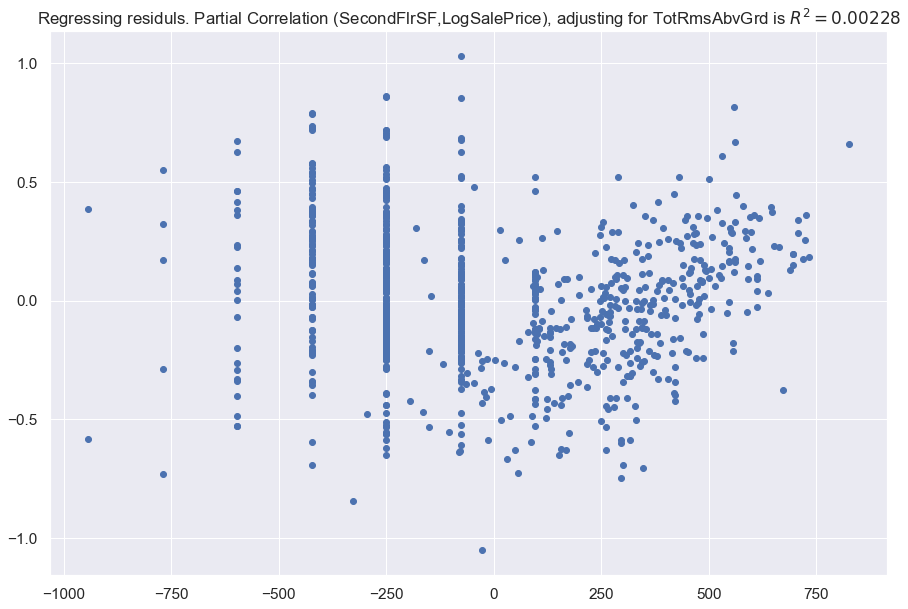



The Partial Correlation between SecondFlrSF, LogSalePrice, adjusted for TotRmsAbvGrd is -0.0478 with p-value = 0.15550




In [13]:
import statsmodels.api as sm
import statsmodels.formula.api as smf


model_SecondFlrSF_TotRmsAbvGrd = sm.OLS(df[varX], sm.add_constant(df[varZ])).fit() 
model_SalePrice_TotRmsAbvGrd = sm.OLS(df[varY], sm.add_constant(df[varZ])).fit() 

plt.figure(figsize=(15, 10))
X = sm.add_constant(model_SecondFlrSF_TotRmsAbvGrd.resid)
y = model_SalePrice_TotRmsAbvGrd.resid
model_res = sm.OLS(y, X).fit()
plt.scatter(model_SecondFlrSF_TotRmsAbvGrd.resid, model_SalePrice_TotRmsAbvGrd.resid)
plt.title(fr"Regressing residuls. Partial Correlation ({varX},{varY}), adjusting for {varZ} is $R^2 = {model_res.rsquared:.5f}$")
plt.show()

corr, p_val = pearsonr(model_SecondFlrSF_TotRmsAbvGrd.resid, model_SalePrice_TotRmsAbvGrd.resid)

print(f"\n\nThe Partial Correlation between {varX}, {varY}, adjusted for {varZ} is {corr:.4f} with p-value = {p_val:.5f}\n\n")

Let's calculate partial correlation with a python library as well:

In [ ]:
! pip install pingouin

In [15]:
import pingouin as pg

varX = 'SecondFlrSF'
varY = 'LogSalePrice'
varZ = 'TotRmsAbvGrd' # total rooms above ground level

pg.partial_corr(data=df, x=varX, y=varY, covar=varZ)

,n,r,CI95%,p-val
pearson,886,-0.047758,"[-0.11, 0.02]",0.155736


It seems that SecondFlrSF, LogSalePrice are NOT significantly NEGATIVELY corrleated. SO, when taking into account TotRmsAbvGrd, not only it is not significant, but it is even NEGATIVE (although not significantally). Based on that (there are other things we can check, of course), I wouldn't recommeand on maximizing second floor area in their designs

## Problem 2 (Variable Selection)

Use the house prices dataset from class. Load it using the function ``load_house_prices_data``. 

1. Write the function ``backward_select`` (prototype below). Apply it on the house prices dataset and report the resulting model. 
2. Write a function that receives as an input a set of predictors and the response and evaluates the leave-one-out accuracy (n-fold cross validation). What is the CV-error of the model you found in 1 ?
3. Consider the predictors ``OverallCond``, ``YearBuilt``, ``LotArea``, ``Fireplaces``. Go over all $2^4$ models. Evaluate $R^2$, AIC, BIC, and leave-one-out CV-error for every model and print the results. Report on the model with lowest AIC, BIC, CV-error. 

Hint: for 1, modify the ``forward_select`` function from class.

1. Write the function ``backward_select`` (prototype below). Apply it on the house prices dataset and report the resulting model. 

In [16]:
from scipy.stats import f

def backward_select(data, response, sig_level=.05):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data: pandas DataFrame with all possible predictors and response

    response: string, name of response column in data
    
    sig_level:  significance level for F-test

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept selected by backward selection
           evaluated by R-squared and F-test for extra sum of squares
    """
    remaining = [c for c in data.columns if not c == response]
    
    n = len(data)
    Ftest_pval = sig_level + 1000
    
    formula = f"{response} ~ {' + '.join(remaining)} + 1"
    fitted_model = smf.ols(formula, data).fit()
    SS_prev = fitted_model.ssr
    
    itr = 0
    while remaining and Ftest_pval > sig_level:
        itr += 1
        R2_without_candidates = []
        SS_without_candidates = {}
        for candidate in remaining:
            # copy the predictors list, remove the current candidate
            cur_vars = remaining.copy()
            cur_vars.remove(candidate)
            varst = ' + '.join(cur_vars)
            formula = f"{response} ~ {varst} + 1"
            fitted_model = smf.ols(formula, data).fit()
            R2 = fitted_model.rsquared
            SS_candidate = fitted_model.ssr
            R2_without_candidates.append((R2, candidate))
            SS_without_candidates[candidate] = SS_candidate

        R2_without_candidates.sort()
        best_new_R2, best_candidate = R2_without_candidates[-1]
        SS_new = SS_without_candidates[best_candidate]
        
        dof = n - 1 - len(remaining)
        f_statistic = (SS_new - SS_prev) / (SS_new / dof)
        Ftest_pval = f.sf(f_statistic, dfn = 1, dfd = dof)
        SS_prev = SS_new
        print(f"=========  Step {itr} ==========")
        print(f"Best Candidate = {best_candidate}")
        print(f"Best R2 = {best_new_R2}")
        print(f"Ftest = {Ftest_pval}")
        print("=============================")
        
        if Ftest_pval > sig_level:
              remaining.remove(best_candidate)

        else:
              print(f"We do not remove {best_candidate}")

    formula = f"{response} ~ {' + '.join(remaining)} + 1"
    model = smf.ols(formula, data).fit()
    
    # return the predictors as well
    return model, remaining


In [17]:
ALPHA = 0.05
best_model, best_predictors = backward_select(df, "LogSalePrice", sig_level=ALPHA)

=========  Step 1 ==========
Best Candidate = GrLivArea
Best R2 = 0.8813367852737969
Ftest = 1.0
=========  Step 2 ==========
Best Candidate = FullBath
Best R2 = 0.8813350484789908
Ftest = 0.9103874286163169
=========  Step 3 ==========
Best Candidate = YrSold
Best R2 = 0.8812921142367409
Ftest = 0.5756384767273961
=========  Step 4 ==========
Best Candidate = LowQualFinSF
Best R2 = 0.8812528137058984
Ftest = 0.5921106921724684
=========  Step 5 ==========
Best Candidate = TotRmsAbvGrd
Best R2 = 0.8811980397794528
Ftest = 0.5269179580446797
=========  Step 6 ==========
Best Candidate = MoSold
Best R2 = 0.8808674469399729
Ftest = 0.12059921742528022
=========  Step 7 ==========
Best Candidate = LotFrontage
Best R2 = 0.8802578964195794
Ftest = 0.03551866997909482
We do not remove LotFrontage


In [18]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           LogSalePrice   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     460.0
Date:                Wed, 08 Jun 2022   Prob (F-statistic):               0.00
Time:                        15:02:51   Log-Likelihood:                 660.01
No. Observations:                 886   AIC:                            -1290.
Df Residuals:                     871   BIC:                            -1218.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.3569      0.419      8.008      0.000       2.534       4.180
LotArea       1.105e-05   2.14e-06      5.153      0.000    6.84e-06    1.53e-05
YearBuilt        0.0036      0.000     16.854      0.000       0.003       0.004
Fireplaces       0.0272      0.008      3.448      0.001       0.012       0.043
GarageCars       0.0347      0.009      3.935      0.000       0.017       0.052
ScreenPorch      0.0002   9.33e-05      2.502      0.013    5.03e-05       0.000
HalfBath         0.0288      0.012      2.460      0.014       0.006       0.052
BedroomAbvGr    -0.0379      0.008     -4.989      0.000      -0.053      -0.023
FirstFlrSF       0.0003   2.45e-05     11.386      0.000       0.000       0.000
SecondFlrSF      0.0003   1.86e-05     15.061      0.000       0.000       0.000
TotalBsmtSF      0.0002    1.9e-05      9.081      0.000       0.000       0.000
LotFrontage      0.0007      0.000      2.111      0.035     4.8e-05       0.001
WoodDeckSF       0.0001   3.94e-05      3.286      0.001    5.22e-05       0.000
OverallQual      0.0733      0.005     13.800      0.000       0.063       0.084
OverallCond      0.0583      0.005     12.609      0.000       0.049       0.067
==============================================================================
Omnibus:                      154.337   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              994.896
Skew:                          -0.615   Prob(JB):                    9.14e-217
Kurtosis:                       8.043   Cond. No.                     1.03e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.03e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

2. Write a function that receives as an input a set of predictors and the response and evaluates the leave-one-out accuracy (n-fold cross validation). What is the CV-error of the model you found in 1 ?


In [19]:
RANDOM_SEED = 123

def Kfold_squared_error(predictors, response, k=len(df)):
    """
    A function that evaluates the K-FOLD mean sauared error of the OLS model on our dataset.
    Could be extented to use other metrics, but not currently.
    """
    X = df[predictors].values
    y = df[response].values
    temp_data = np.column_stack((X, y))

    np.random.seed(RANDOM_SEED)
    np.random.shuffle(temp_data)

    X, y = temp_data[:, : -1], temp_data[:, -1]    
    X = sm.add_constant(X)

    fold_size = len(y) // k
    start_test_fold = 0
    end_test_fold = fold_size
    errors_list = list()
    for _fold in range(k):
        # train
        X_train_fold = np.concatenate( (X[: start_test_fold], X[end_test_fold: ] ), axis=0) # concat rows before and after the test partition of the X
        y_train_fold = np.concatenate( (y[: start_test_fold], y[end_test_fold: ] ), axis=0) # concat rows before and after the test partition of the y
                
        # test
        X_test_fold = X[start_test_fold: end_test_fold]
        y_test_fold = y[start_test_fold: end_test_fold]

        # fit the model
        fitted_model = sm.OLS(y_train_fold, X_train_fold).fit()

        predictions = fitted_model.predict(X_test_fold)
        fold_error = y_test_fold - predictions
        errors_list.append(fold_error)
        
        start_test_fold += fold_size
        end_test_fold += fold_size

        if _fold == k-1:  # if it's the last iteration
            end_test_fold = -1  # take all the remaining rows

    return np.mean(np.array(errors_list) ** 2)

In [20]:
response = "LogSalePrice"
mean_squared_error = Kfold_squared_error(predictors=predictors_cols, response=response, k=len(df))
print(f"The CV-error of the model found in section 1, with leave-one-out cross validation (N-FOLD) is: {mean_squared_error:.5f}")

The CV-error of the model found in section 1, with leave-one-out cross validation (N-FOLD) is: 0.01379


3. Consider the predictors ``OverallCond``, ``YearBuilt``, ``LotArea``, ``Fireplaces``. Go over all $2^4$ models. Evaluate $R^2$, AIC, BIC, and leave-one-out CV-error for every model and print the results. Report on the model with lowest AIC, BIC, CV-error. 


In [21]:
from itertools import combinations

predictors_less = ['OverallCond', 'YearBuilt', 'LotArea', 'Fireplaces']

predictors_combs = [("constant")]  # only constant will predict just the mean of the response as a model.
for comb_length in range(1, 5):
    predictors_combs += list(combinations(predictors_less, r=comb_length))

assert len(predictors_combs) == 2 ** len(predictors_less), "combs error"

In [22]:
r_squared_dict, cv_kfold_mean_se_dict, aic_dict, bic_dict = dict(), dict(), dict(), dict()
y = df[response]
df_with_constant = df.copy()
df["constant"] = np.ones_like(y)

# go over all combinations
for predictors_comb in predictors_combs:
    if predictors_comb == ("constant"): 
        current_x = df[predictors_comb] # will take ONLY the constant
        predictors_comb_list = [predictors_comb]
    else:
        predictors_comb_list = list(predictors_comb)
        current_x = sm.add_constant(df[predictors_comb_list])

    # fit the model
    fitted_model = sm.OLS(y, current_x).fit()

    r_squared = fitted_model.rsquared
    r_squared_dict[predictors_comb] = r_squared

    # leave-one-out error
    cv_kfold_mean_se = Kfold_squared_error(predictors_comb_list, response=response, k=len(df))
    cv_kfold_mean_se_dict[predictors_comb] = cv_kfold_mean_se

    # AIC, BIC
    ss_res = ssr = fitted_model.ssr
    p = len(predictors_comb) + 1
    n = len(y)

    aic = n * np.log(ss_res / n) + 2 * p
    bic = n * np.log(ss_res / n) + p * np.log(n)

    aic_dict[predictors_comb] = aic
    bic_dict[predictors_comb] = bic

    print(f"\nFor model with predictors: {', '.join(predictors_comb)}, \n \t R^2 = {r_squared:.4f} \n \t cross vlaidated leave-one-out error = {cv_kfold_mean_se:.4f}"
          f"\n \t AIC = {aic:.5f}\n \t BIC = {bic:.5f} ")
    

min_cv_kfold_mean_se_predictors = min(cv_kfold_mean_se_dict, key=cv_kfold_mean_se_dict.get)
min_aic_predictors = min(aic_dict, key=aic_dict.get)
min_bic_predictors = min(bic_dict, key=bic_dict.get)

print(f"\n\n\nLowest CV-error with leave-one-out cross validation (N-FOLD) = {cv_kfold_mean_se_dict[min_cv_kfold_mean_se_predictors]:.4f}, for predictors: {', '.join(min_cv_kfold_mean_se_predictors)}")
print(f"Lowest AIC = {aic_dict[min_aic_predictors]:.4f}, that's with predictors: {', '.join(min_aic_predictors)}")
print(f"Lowest BIC = {bic_dict[min_bic_predictors]:.4f}, that's with predictors: {', '.join(min_bic_predictors)}")



For model with predictors: c, o, n, s, t, a, n, t, 
 	 R^2 = 0.0000 
 	 cross vlaidated leave-one-out error = 0.1110
 	 AIC = -1931.40059
 	 BIC = -1888.32013 

For model with predictors: OverallCond, 
 	 R^2 = 0.0351 
 	 cross vlaidated leave-one-out error = 0.1074
 	 AIC = -1977.01378
 	 BIC = -1967.44035 

For model with predictors: YearBuilt, 
 	 R^2 = 0.4590 
 	 cross vlaidated leave-one-out error = 0.0602
 	 AIC = -2489.74126
 	 BIC = -2480.16783 

For model with predictors: LotArea, 
 	 R^2 = 0.1261 
 	 cross vlaidated leave-one-out error = 0.0973
 	 AIC = -2064.78454
 	 BIC = -2055.21110 

For model with predictors: Fireplaces, 
 	 R^2 = 0.1802 
 	 cross vlaidated leave-one-out error = 0.0913
 	 AIC = -2121.42191
 	 BIC = -2111.84847 

For model with predictors: OverallCond, YearBuilt, 
 	 R^2 = 0.4772 
 	 cross vlaidated leave-one-out error = 0.0583
 	 AIC = -2518.05805
 	 BIC = -2503.69790 

For model with predictors: OverallCond, LotArea, 
 	 R^2 = 0.1542 
 	 cross vlaidate

## Problem 3 (Selecting Order of Regression using Cross-Validation)

Consider the dataset ``AnneFrank.csv``, describing the number of searches of the term "Anne Frank" by hour over several days in February 2022. The cell below contains code you should use to arrange the data by hours. 

/var/folders/41/21yq_s992776m2qf34b8yrq40000gn/T/ipykernel_44919/1893182961.py:3: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  AnneFrank['time'] = AnneFrank['date'].astype(int) / 3600000000000


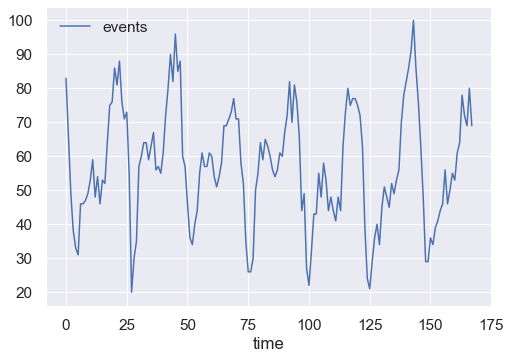

In [41]:
AnneFrank = pd.read_csv("AnneFrank.csv", header=1, names=['time', 'events'])
AnneFrank['date'] = pd.to_datetime(AnneFrank.time)
AnneFrank['time'] = AnneFrank['date'].astype(int) / 3600000000000
AnneFrank['time'] = AnneFrank['time'] - AnneFrank['time'].min()
AnneFrank.plot(x='time', y='events'); plt.show()

In [42]:
af = AnneFrank.copy()
af.describe()

,time,events
count,168.000000,168.000000
mean,83.500000,57.261905
std,48.641546,16.970294
min,0.000000,20.000000
25%,41.750000,46.000000
50%,83.500000,56.500000
75%,125.250000,70.250000
max,167.000000,100.000000


In this question you will fit a model to the response based on $2p+1$ predictors of the form:
$$
\begin{align}
x_1 = [1,~\ldots~,1]
\end{align}
$$
$$
\begin{align}
x_{2k} & = \sin(2 \pi \cdot k \cdot t / 60) \\
x_{2k+1} & = \cos(2 \pi \cdot k \cdot t / 60), \qquad k=1,\ldots,p.
\end{align}
$$
(these are sinusoids of increaasing frequency at a resolution of 1min) You will then use the selected model to predict the number of events in future times. 

1. Write a function ``generate_Z`` that recieves as inputs a vector of time indices (representing hours) ``t`` and ``p``. The function returns the design matrix $Z$ of size $n \times (2p+1)$, where $n$ is the length of ``t``.
2. For each $p=1,\ldots,20$, fit a linear model to ``events`` based on $Z$ you obtain from ``generate_Z`` and evalaute its leave-one-out CV error. Plot the CV error versus $p$. 
3. Report on the model with the lowest CV error; plot its response over time along with the original response in the figure above. 
4. Using the model you found in 3, predict the number of event at times $t=168.\ldots,190$. Plot your prediction over time in the same figure as above, i.e., interpolate the response curve to future value. 
5. For each $t$ in 4, construct a 0.95 confidence interval of your prediction of $y_t$, $t=168,\ldots,190$. Plot the upper and lower limits of this interval over time (these lines define a prediction band). Here, you may ignore the danger of inference based on the t distribution after applying a model selection procedure. 

Hints: (2) In order to evalaute the CV error, you'll need the hat matrix (which you can get directly from Z) and the residuals in the LS fit (which you can get from the ``resid`` property of the fitted model object returned by ``statsmodels.api.OLS.fit``). (4) you can use the function ``predict`` of the fitted model object by passing new predictors that you generate using ``generate_Z``. For (5), $s^2$ is given by the property ``mse_resid`` (or ``ssr`` divided by the number of degrees of freedom). Also note that the number of degrees of freedom is $2p+1$ where $p$ is the number you found in 3. 

1. Write a function ``generate_Z`` that recieves as inputs a vector of time indices (representing hours) ``t`` and ``p``. The function returns the design matrix $Z$ of size $n \times (2p+1)$, where $n$ is the length of ``t``.\

In [43]:
def generate_Z(t, p):
    """
    Args:
    ----
    t:   vector of time samples (length n)
    p:   number of frequencies (overal 2p+1 predictors)
    
    Returns:
    --------
    Z:  design matrix of size (n, 2p+1)
    """    
    Z = np.ones_like(t)
    
    for k in range(1, p+1):
        Z = np.hstack((Z,
        np.sin(2 * np.pi * k * (t / 60)),
        np.cos(2 * np.pi * k * (t / 60)))
        )
    
    return Z

2. For each $p=1,\ldots,20$, fit a linear model to ``events`` based on $Z$ you obtain from ``generate_Z`` and evalaute its leave-one-out CV error. Plot the CV error versus $p$. 

In [44]:
def one_out_cv_mean_error(Z, y):
    """
    This function will use the 'shortcut' we learned in class in order to calculate leave-one-out CV error.
    """
    Z_p_inv = np.linalg.inv(Z.T @ Z) @ Z.T
    
    H = Z @ Z_p_inv
    
    betas_hat = Z_p_inv @ y
    residuals_squared = (y - Z @ betas_hat) ** 2
    
    H_ii = H.diagonal()
    
    sqr_errors_w_shortcut = residuals_squared / ((1 - H_ii) ** 2)
    
    return np.mean(sqr_errors_w_shortcut), betas_hat

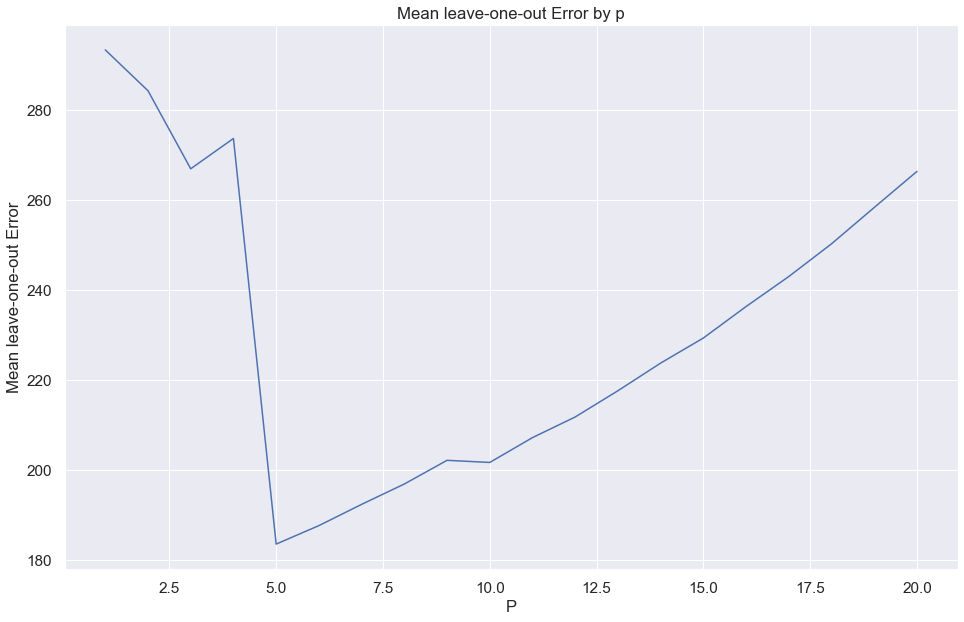

In [45]:
y = af['events'].values.reshape(-1, 1)
t = af['time'].values.reshape(-1, 1)

cv_errors = list()
min_cv_error = np.inf
min_cv_error_p = 0
for p in range(1, 21):
    Z = generate_Z(t, p)
    cv_err, betas_hat = one_out_cv_mean_error(Z, y)
    cv_errors.append(cv_err)
    if cv_err < min_cv_error:
        min_cv_error = cv_err
        min_cv_error_p = p
        min_cv_error_Z = Z
        min_cv_error_betas_hat = betas_hat
        
plt.figure(figsize=(16, 10))
plt.plot(range(1, 21), cv_errors)
plt.title("Mean leave-one-out Error by p")
plt.xlabel("P")
plt.ylabel("Mean leave-one-out Error")
plt.show()

3. Report on the model with the lowest CV error; plot its response over time along with the original response in the figure above. 


In [46]:
print(f"The model with the lowest leave-one-out mean error = {min_cv_error:.2f} is with p = {min_cv_error_p}")

The model with the lowest leave-one-out mean error = 183.63 is with p = 5


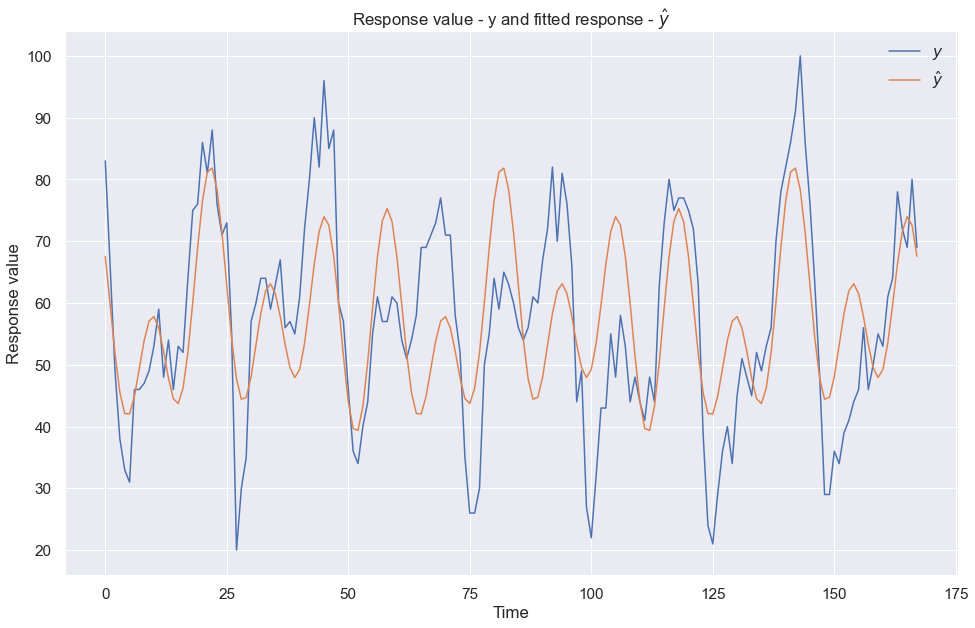

In [47]:
y_hat = min_cv_error_Z @ min_cv_error_betas_hat  # use the model with the lowest CV error

plt.figure(figsize=(16, 10))
plt.plot(t, y, label="$y$")
plt.plot(t, y_hat, label="$\hat{y}$")
plt.title("Response value - y and fitted response - $\hat{y}$")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Response value")
plt.show()

4. Using the model you found in 3, predict the number of event at times $t=168.\ldots,190$. Plot your prediction over time in the same figure as above, i.e., interpolate the response curve to future value. 

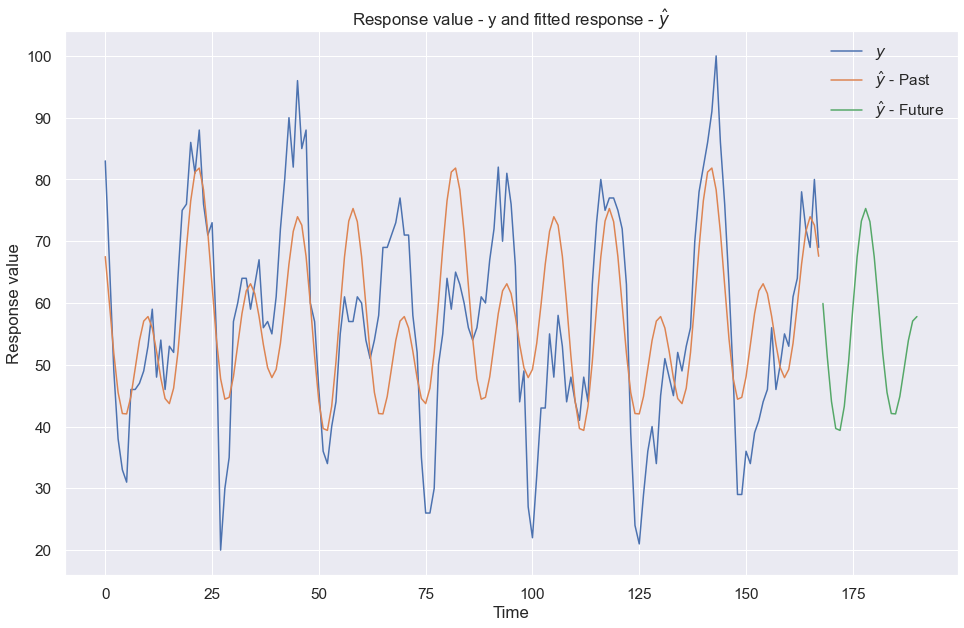

In [50]:
t_future = np.arange(168, 191).reshape(-1,1)

Z_future = generate_Z(t_future, min_cv_error_p)
y_hat_future = Z_future @ min_cv_error_betas_hat

plt.figure(figsize=(16, 10))
plt.plot(t, y, label="$y$")
plt.plot(t, y_hat, label="$\hat{y}$ - Past")
plt.plot(t_future, y_hat_future, label="$\hat{y}$ - Future")
plt.title("Response value - y and fitted response - $\hat{y}$")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Response value")
plt.show()

5. For each $t$ in 4, construct a 0.95 confidence interval of your prediction of $y_t$, $t=168,\ldots,190$. Plot the upper and lower limits of this interval over time (these lines define a prediction band). Here, you may ignore the danger of inference based on the t distribution after applying a model selection procedure. 


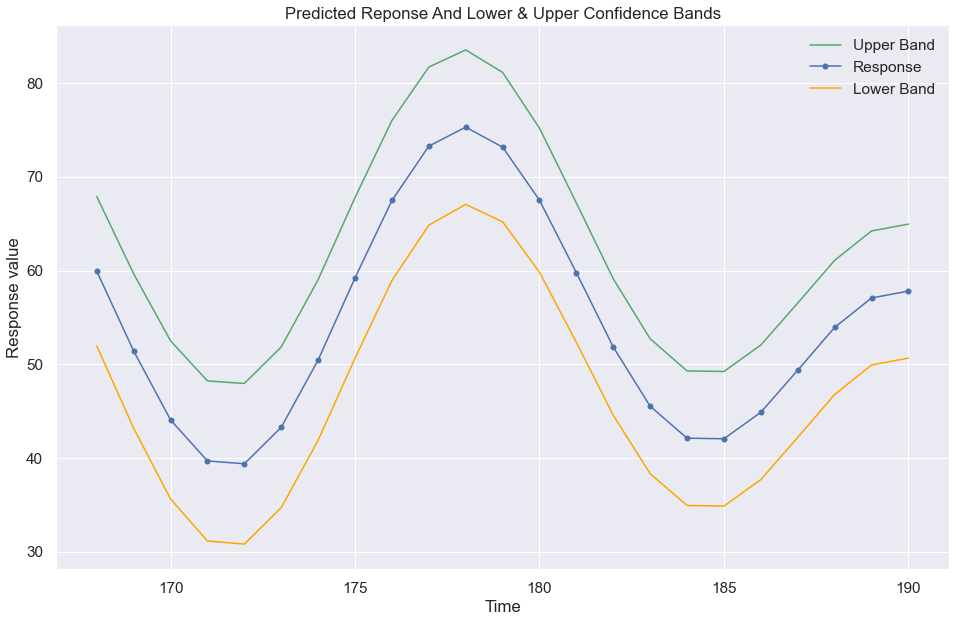

In [56]:
from scipy.stats import t as t_test

ALPHA = 0.05
n = len(y)
dof = 2 * min_cv_error_p + 1
t_statistic = t_test.ppf(1 - ALPHA / 2, dof)

residuals = y - min_cv_error_Z @ min_cv_error_betas_hat 
s_sqr = (residuals.T @ residuals) / (n - dof)
s = np.sqrt(s_sqr).flatten()[0]

upper_bands, lower_bands = list(), list()
for index, row in enumerate(Z_future):
    row_vector = row.reshape(-1, 1)
    b_sqr = row_vector.T @ np.linalg.inv(min_cv_error_Z.T @ min_cv_error_Z) @ row_vector  # self note: from the lecture on prediction bands (lecture 9), page 1
    b = np.sqrt(b_sqr).flatten()

    # get the lower and upper bands
    band = t_statistic * s * b
    upper_band = y_hat_future[index] + band
    lower_band = y_hat_future[index] - band

    upper_bands.append(upper_band)
    lower_bands.append(lower_band)

upper_band = np.asarray(upper_band)
lower_band = np.asarray(lower_band)

# plot
plt.figure(figsize=(16, 10))
plt.plot(t_future, upper_bands, label="upper band".title(), color="g")
plt.plot(t_future, y_hat_future, "-o", label="Response", color="b")
plt.plot(t_future, lower_bands, label="lower band".title(), color="orange")
plt.title("Predicted reponse and lower & upper Confidence Bands".title())
plt.legend()
plt.xlabel("Time")
plt.ylabel("Response value")
plt.show()